In [45]:
!pip install tqdm
!pip install --upgrade torch torchvision

In [46]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

transform = transforms.Compose([transforms.ToTensor()])

# Load the dataset
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the dataset into three subsets
lengths = [len(mnist) // 3, len(mnist) // 3, len(mnist) - 2*(len(mnist) // 3)]
sample1, sample2, sample3 = random_split(mnist, lengths)

In [47]:
# Split test

print(len(sample1))
print(len(sample2))
print(len(sample3))

20000
20000
20000


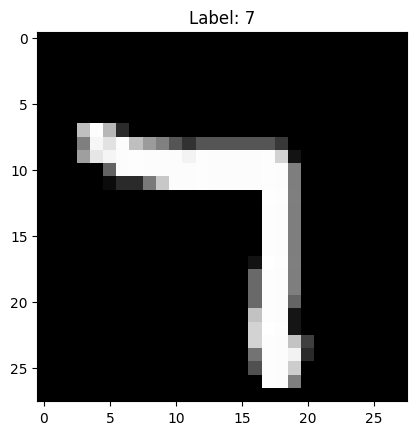

In [48]:
# Case test
import matplotlib.pyplot as plt

image, label = sample1[0]

# Convert from 1x28x28 to 28x28
image = image.squeeze().numpy()

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

# Sample model for testing
class CNN(nn.Module):
  """ConvNet -> Max_Pool -> RELU -> ConvNet ->
  Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [50]:
# Create the initial global model

global_model = CNN()

# Set up the parameters of training and federated learning
lr = 0.01
local_epochs = 3
global_rounds = 5 # Global rounds here should be larger, 5 is just for faster training

In [51]:
from torch.utils.data import DataLoader

batch_size = 32

sample1_dataloader = DataLoader(sample1, batch_size=batch_size, shuffle=True)
sample2_dataloader = DataLoader(sample2, batch_size=batch_size, shuffle=True)
sample3_dataloader = DataLoader(sample3, batch_size=batch_size, shuffle=True)

dataloaders = {
  "sample1": sample1_dataloader,
  "sample2": sample2_dataloader,
  "sample3": sample3_dataloader,
}

In [52]:
def average_weights(state_dicts):
  avg_dict = {}
  for k in state_dicts[0].keys():
    avg_dict[k] = torch.stack([state_dict[k] for state_dict in state_dicts]).mean(dim=0)
  return avg_dict

In [53]:
def evaluate(model, dataloader):
  # Set model to evaluation
  model.eval()
  correct = 0
  with torch.no_grad():
    for data, target in dataloader:
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  accuracy = 100. * correct / len(dataloader.dataset)
  return accuracy

In [54]:
# Store the accuracies

global_accuracies = []
local_accuracies = {
  "sample1": [],
  "sample2": [],
  "sample3": []
}

In [56]:
from tqdm import tqdm
import matplotlib.pyplot as plt

for global_round in range(global_rounds):
  # Show round
  print(f"\nStarting Global Round {global_round+1}/{global_rounds}\n")
  local_models = []
  for sample_name, dataloader in dataloaders.items():
    local_model = CNN()
    local_model.load_state_dict(global_model.state_dict())

    optimizer = optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(local_epochs):
      # Wrap dataloader with tqdm
      for data, target in tqdm(dataloader, desc=f"{sample_name} - Epoch {epoch+1}/{local_epochs}"):
        optimizer.zero_grad()
        output = local_model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    local_models.append(local_model.state_dict())

    acc = evaluate(local_model, dataloader)
    local_accuracies[sample_name].append(acc)

    # FedAvg - average the local models to update the global model
  global_weights = average_weights(local_models)
  global_model.load_state_dict(global_weights)

  combined_dataset = torch.utils.data.ConcatDataset([sample1, sample2, sample3])
  combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False)
  # evaluate global model with combined dataset
  global_acc = evaluate(global_model, combined_dataloader)
  global_accuracies.append(global_acc)


Starting Global Round 1/5



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:19<00:00, 32.64it/s]



Starting Global Round 2/5



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:18<00:00, 33.00it/s]



Starting Global Round 3/5



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:18<00:00, 34.58it/s]



Starting Global Round 4/5



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:19<00:00, 32.35it/s]



Starting Global Round 5/5



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:19<00:00, 32.72it/s]


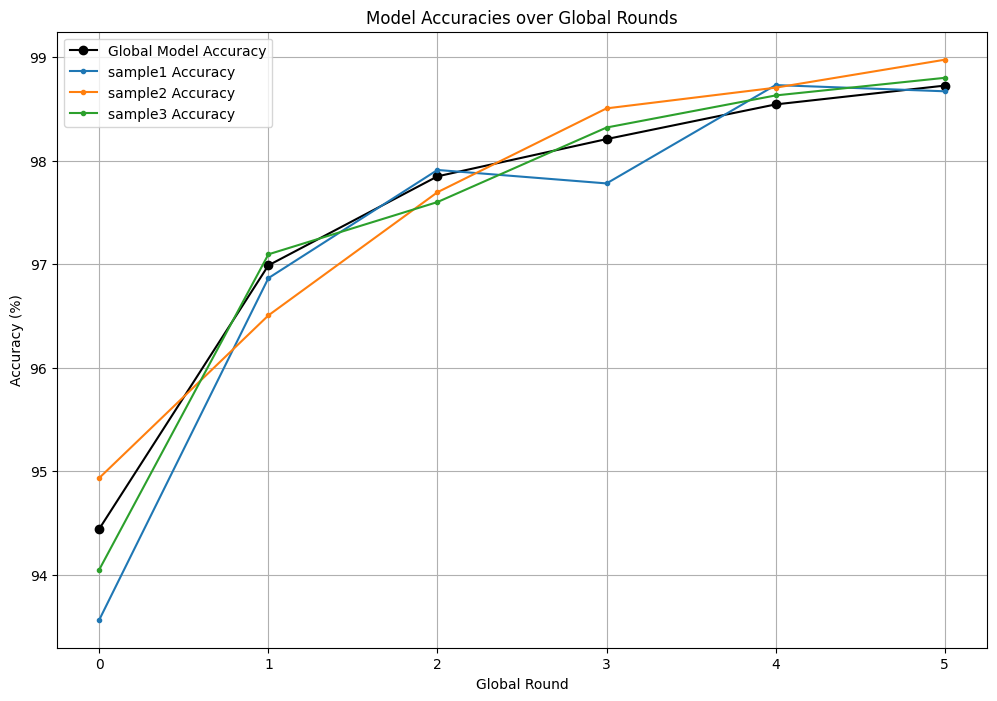

In [58]:
# Plot results

plt.figure(figsize=(12, 8))
plt.plot(global_accuracies, label='Global Model Accuracy', color='black', marker='o')
for sample_name, accuracies in local_accuracies.items():
  plt.plot(accuracies, label=f'{sample_name} Accuracy', marker='.')

plt.title('Model Accuracies over Global Rounds')
plt.xlabel('Global Round')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()